INFO Parameters of the training procedure. 

INFO dataset: MNIST
INFO dataset_file: ../../data
INFO batch_size: 32
INFO test_batch_size: 32
INFO epochs: 20
INFO lr: 0.001
INFO no_cuda: False
INFO seed: 1
INFO log_interval: 200
INFO routing_iterations: 3
INFO with_argmax: False
INFO without_argmax_one: True
INFO with_reconstruction: False
INFO cuda: True
INFO Using CUDA.
Successfully created the directory ./experiments/dynamic_routing_01-06-21_dataset:MNIST_bsz:32_epochs:20_lr:0.001_routiter:3_recon:False_argmax:False_withones:True 
INFO Starting training... for 20 epochs.

INFO Train Epoch: 1 [0/60000 (0%)]	Loss: 0.080862
INFO Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.009557
INFO Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.011814
INFO Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.001790
INFO Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.002698
INFO Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.003397
INFO Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.001770
INFO Train Epoch: 1 [44800/60000 (75%)]	L

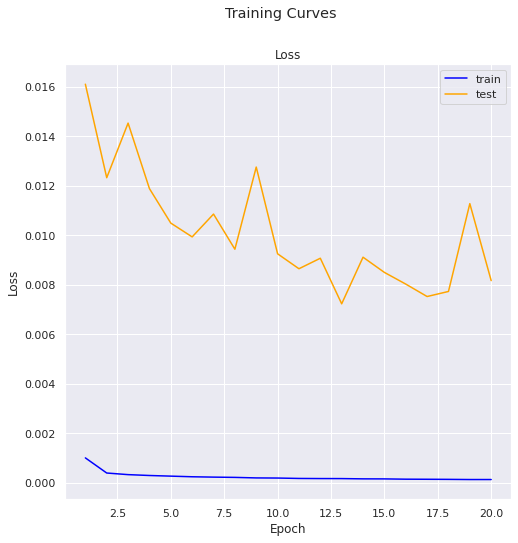

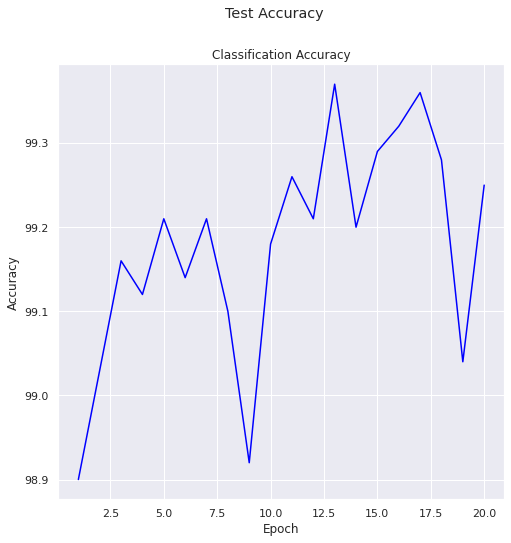

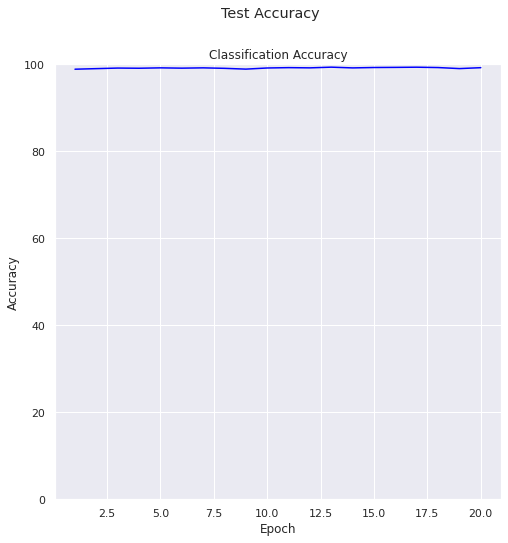

In [6]:
%run net.py --epochs 20

In [8]:
torch.save(model.state_dict(),"experiments.h5")

In [1]:
from net import *

In [2]:
model = CapsNet(routing_iterations=0, n_classes=10,
                    input_channels=1, types_of_primary_caps=32, argmax=0, arg_max_ones=0)
if torch.cuda.device_count():
    model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("experiments.h5"), device)

<All keys matched successfully>

In [3]:
loss_fn = MarginLoss(0.9, 0.1, 0.5)
def test(epoch=0, recon=0):
        """
        Function used to test the Capsule network.

        Returns
        ---------
        test_loss : scalar float number of the loss as computed by test set.
        """
        model.eval() # Change to no training mode.
        test_loss = 0
        correct = 0
        votes = []
        preds =[]

        with torch.no_grad():
            for data, target in test_loader:
                if torch.cuda.device_count():
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)# Variables are depricated.
                                                                                # Use tensors with requires_grad instead.
                                                                                # Volatile sets requires_grad=False and
                                                                                # is used when we do not use .backward()
                if recon:
                    output, probs, all_votes = model(data, target)
                    preds.append(torch.argmax(probs, dim=1).cpu().detach().numpy())
                    reconstruction_loss = F.mse_loss(output, data.view(-1, in_channels* 28 * 28), reduction='sum').data.item()  # 28 == hight == width
                    test_loss += loss_fn(probs, target, size_average=False).data.item()
                    test_loss += reconstruction_alpha * reconstruction_loss
                else:
                    output, probs, all_votes = model(data)
                    preds.append(torch.argmax(probs, dim=1).cpu().detach().numpy())
                    test_loss += loss_fn(probs, target, size_average=False).data.item()
                votes.append(all_votes.cpu().detach().numpy())
                pred = probs.data.max(1, keepdim=True)[1] # get the index of the max probability
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            test_loss /= len(test_loader.dataset)
            acc = 100. * correct / len(test_loader.dataset)
            print('Test Epoch:{} Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(epoch, 
            test_loss, correct, len(test_loader.dataset), acc.data.item()))
        return test_loss, acc.data.item(), votes, preds


In [4]:
from torchvision import datasets, transforms
test_loader = torch.utils.data.DataLoader(
            datasets.MNIST("../../data", train=False, transform=transforms.Compose([
                transforms.ToTensor()
            ])),
            batch_size=16, shuffle=False)

In [5]:
test_loss, test_acc, all_votes0, preds= test()


Test Epoch:0 Average loss: 0.1129, Accuracy: 9912/10000 (99.1%)



In [6]:
norms0 = list(map(lambda x: np.linalg.norm(x, axis=-1), all_votes0))

In [11]:
preds[0]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5])

In [7]:
import seaborn as sns
sns.set(rc={"figure.figsize":(16, 10)})
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
def get_positive(norms, number):
    result = []
    for batch, (_, target) in enumerate(test_loader):
        result.append(norms[batch][target.cpu().detach().numpy()==number,:,:])
        print(target.cpu().detach().numpy())
    res = np.concatenate(result)
    return res

In [10]:

for batch, (_, target) in enumerate(test_loader):
    if batch==1:
        break
    print(target.cpu().detach().numpy())

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]


In [12]:
def test_a_number(all_votes0, n, batch):
    conf = np.zeros(shape=(10,10),dtype=np.float)
    for i in range(10):
        for j in range(10):
            r = ((all_votes0[batch][n,:,i,:].reshape(-1,16)/np.expand_dims(np.linalg.norm(all_votes0[batch][n,:,i,:],axis=-1),axis=-1)) @ 
            (all_votes0[batch][n,:,j,:].reshape(-1,16)/np.expand_dims(np.linalg.norm(all_votes0[batch][n,:,j,:], axis=-1), axis=-1)).T)
            conf[i,j] = r.mean()
    return conf

<AxesSubplot:>

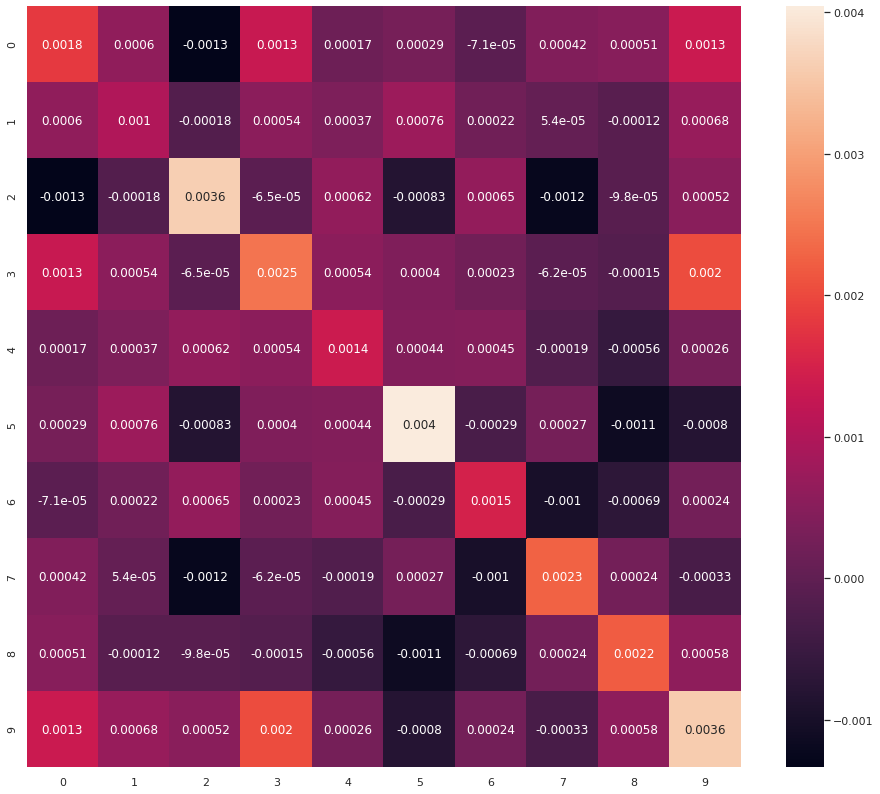

In [19]:
sns.set(rc={'figure.figsize':(16,14)})
plt.grid()
plt.xticks(ticks=range(10))
plt.yticks(ticks=range(10))
sns.heatmap(test_a_number(all_votes0, 3, 0), annot=True)

<AxesSubplot:>

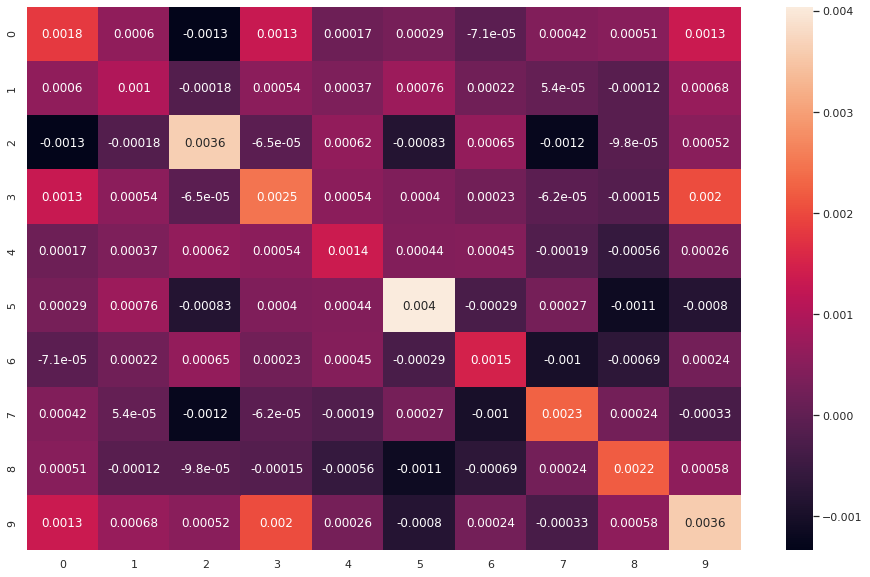

In [12]:
plt.grid()
plt.xticks(ticks=range(10))
plt.yticks(ticks=range(10))
sns.heatmap(test_a_number(all_votes0, 3, 0), annot=True)

In [95]:
res = get_positive(norms0,0)

 4 0 2 7 4 3 3 0 0 3 1 9 6 5 2 5]
[9 2 9 3 0 4 2 0 7 1 1 2 1 5 3 3 9 7 8 6 5 6 1 3 8 1 0 5 1 3 1 5]
[5 6 1 8 5 1 7 9 4 6 2 2 5 0 6 5 6 3 7 2 0 8 8 5 4 1 1 4 0 3 3 7]
[6 1 6 2 1 9 2 8 6 1 9 5 2 5 4 4 2 8 3 8 2 4 5 0 3 1 7 7 5 7 9 7]
[1 9 2 1 4 2 9 2 0 4 9 1 4 8 1 8 4 5 9 8 8 3 7 6 0 0 3 0 2 6 6 4]
[9 3 3 3 2 3 9 1 2 6 8 0 5 6 6 6 3 8 8 2 7 5 8 9 6 1 8 4 1 2 5 9]
[1 9 7 5 4 0 8 9 9 1 0 5 2 3 7 8 9 4 0 6 3 9 5 2 1 3 1 3 6 5 7 4]
[2 2 6 3 2 6 5 4 8 9 7 1 3 0 3 8 3 1 9 3 4 4 6 4 2 1 8 2 5 4 8 8]
[4 0 0 2 3 2 7 7 0 8 7 4 4 7 9 6 9 0 9 8 0 4 6 0 6 3 5 4 8 3 3 9]
[3 3 3 7 8 0 8 2 1 7 0 6 5 4 3 8 0 9 6 3 8 0 9 9 6 8 6 8 5 7 8 6]
[0 2 4 0 2 2 3 1 9 7 5 1 0 8 4 6 2 6 7 9 3 2 9 8 2 2 9 2 7 3 5 9]
[1 8 0 2 0 5 2 1 3 7 6 7 1 2 5 8 0 3 7 2 4 0 9 1 8 6 7 7 4 3 4 9]
[1 9 5 1 7 3 9 7 6 9 1 3 7 8 3 3 6 7 2 8 5 8 5 1 1 4 4 3 1 0 7 7]
[0 7 9 4 4 8 5 5 4 0 8 2 1 0 8 4 5 0 4 0 6 1 7 3 2 6 7 2 6 9 3 1]
[4 6 2 5 4 2 0 6 2 1 7 3 4 1 0 5 4 3 1 1 7 4 9 9 4 8 4 0 2 4 5 1]
[1 6 4 7 1 9 4 2 4 1 5 5 3 8 3 1 4 5 6 8 9

In [91]:
res.shape

(980, 1152, 10)

In [27]:
def plot_usefull(norm, number):
    res = get_positive(norm,number)
    data = pd.DataFrame(res.reshape((-1,10)))
    plt.errorbar(x=range(10),y=data.mean(),yerr=data.std(), ecolor='red', linestyle="None", marker="_")
    plt.xticks(ticks=range(10))
    plt.show()
    
    sns.boxplot(data=data, orient="h", palette="Set2")
    plt.show()

 4 3 8]
[0 9 6 3 8 0 9 9 6 8 6 8 5 7 8 6]
[0 2 4 0 2 2 3 1 9 7 5 1 0 8 4 6]
[2 6 7 9 3 2 9 8 2 2 9 2 7 3 5 9]
[1 8 0 2 0 5 2 1 3 7 6 7 1 2 5 8]
[0 3 7 2 4 0 9 1 8 6 7 7 4 3 4 9]
[1 9 5 1 7 3 9 7 6 9 1 3 7 8 3 3]
[6 7 2 8 5 8 5 1 1 4 4 3 1 0 7 7]
[0 7 9 4 4 8 5 5 4 0 8 2 1 0 8 4]
[5 0 4 0 6 1 7 3 2 6 7 2 6 9 3 1]
[4 6 2 5 4 2 0 6 2 1 7 3 4 1 0 5]
[4 3 1 1 7 4 9 9 4 8 4 0 2 4 5 1]
[1 6 4 7 1 9 4 2 4 1 5 5 3 8 3 1]
[4 5 6 8 9 4 1 5 3 8 0 3 2 5 1 2]
[8 3 4 4 0 8 8 3 3 1 7 3 5 9 6 3]
[2 6 1 3 6 0 7 2 1 7 1 4 2 4 2 1]
[7 9 6 1 1 2 4 8 1 7 7 4 8 0 7 3]
[1 3 1 0 7 7 0 3 5 5 2 7 6 6 9 2]
[8 3 5 2 2 5 6 0 8 2 9 2 8 8 8 8]
[7 4 9 3 0 6 6 3 2 1 3 2 2 9 3 0]
[0 5 7 8 1 4 4 6 0 2 9 1 4 7 4 7]
[3 9 8 8 4 7 1 2 1 2 2 3 2 3 2 3]
[9 1 7 4 0 3 5 5 8 6 3 2 6 7 6 6]
[3 2 7 8 1 1 7 5 6 4 9 5 1 3 3 4]
[7 8 9 1 1 6 9 1 4 4 5 4 0 6 2 2]
[3 1 5 1 2 0 3 8 1 2 6 7 1 6 2 3]
[9 0 1 2 2 0 8 9 9 0 2 5 1 9 7 8]
[1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4]
[4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7]
[1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7]
[2 4 9

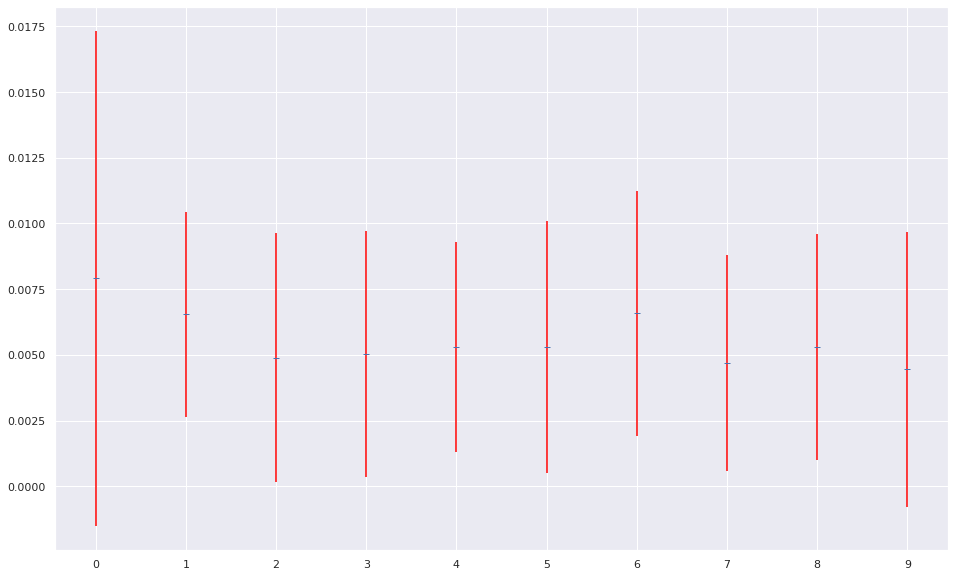

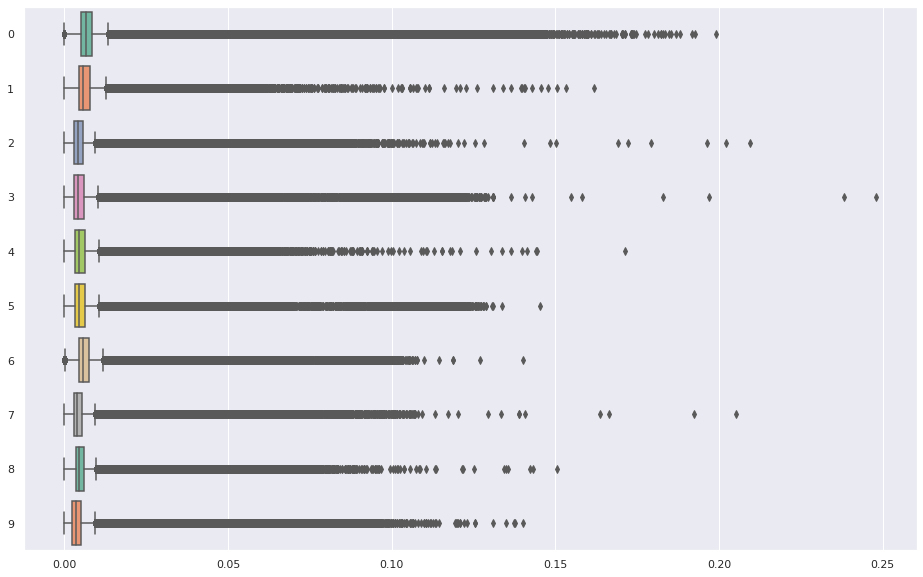

In [28]:
plot_usefull(norms0,0)

In [26]:
del norms0, all_votes0

In [11]:
model = CapsNet(1, n_classes=output_classes,
                    input_channels=in_channels, types_of_primary_caps=types_of_primary_caps, argmax=args.with_argmax, arg_max_ones=args.without_argmax_one)
if args.cuda:
    model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("experiments.h5"), device)

<All keys matched successfully>

In [11]:
test_loss, test_acc, all_votes1 = test(epoch)

In [3]:
norms1 = list(map(lambda x: np.linalg.norm(x, axis=-1), all_votes1))

NameError: name 'all_votes1' is not defined

In [ ]:
model = CapsNet(2, n_classes=output_classes,
                    input_channels=in_channels, types_of_primary_caps=types_of_primary_caps, argmax=args.with_argmax, arg_max_ones=args.without_argmax_one)
if args.cuda:
    model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("experiments.h5"), device)

In [ ]:
test_loss, test_acc, all_votes2 = test(epoch)

In [ ]:
norms2 = list(map(lambda x: np.linalg.norm(x, axis=-1), all_votes2))

In [ ]:
model = CapsNet(3, n_classes=output_classes,
                    input_channels=in_channels, types_of_primary_caps=types_of_primary_caps, argmax=args.with_argmax, arg_max_ones=args.without_argmax_one)
if args.cuda:
    model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("experiments.h5"), device)

In [ ]:
test_loss, test_acc, all_votes3 = test(epoch)

In [ ]:
norms3 = list(map(lambda x: np.linalg.norm(x, axis=-1), all_votes3))

In [30]:
model = CapsNet(routing_iterations=5, n_classes=10,
                    input_channels=1, types_of_primary_caps=32, argmax=0, arg_max_ones=0)
if torch.cuda.device_count():
    model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("experiments.h5"), device)

<All keys matched successfully>

In [31]:
test_loss, test_acc, all_votes5 = test()

In [1]:
norms5 = list(map(lambda x: np.linalg.norm(x, axis=-1), all_votes5))

NameError: name 'all_votes5' is not defined

In [2]:
plot_usefull(norms5,0)

NameError: name 'plot_usefull' is not defined

In [ ]:
temp = (all_votes[0] @ all_votes[0].T)


In [ ]:
(all_votes[0]* all_votes[0].T).shape

In [14]:
plt.figure(figsize=(12,12))

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

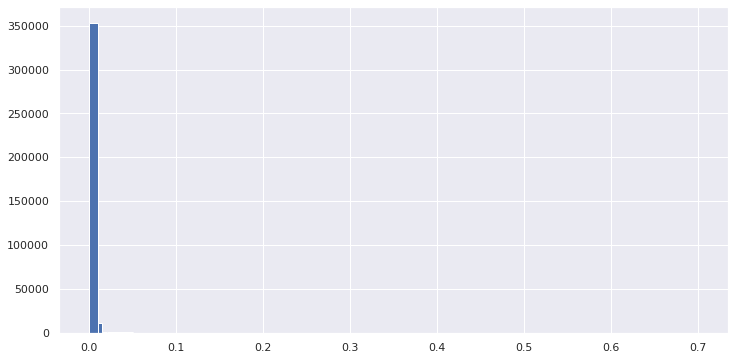

In [39]:
plt.figure(figsize=(12,6))
a= plt.hist(norms[0].flatten(), bins=[0,0.01,0.015,0.02,0.05,0.08,0.1,0.15,0.2,0.3,0.5,0.7])
plt.show()

In [40]:
a

(array([3.53267e+05, 1.18470e+04, 1.92200e+03, 1.34900e+03, 1.48000e+02,
        4.30000e+01, 5.60000e+01, 8.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00]),
 array([0.   , 0.01 , 0.015, 0.02 , 0.05 , 0.08 , 0.1  , 0.15 , 0.2  ,
        0.3  , 0.5  , 0.7  ]),
 <BarContainer object of 11 artists>)